## PREDICTING OPTIMAL LOCATION TO OPEN RESTAURANTS TARGETING TOURISTS IN TOP THREE POPULATED CITIES IN UNITED STATES OF AMERICA.

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json

import requests
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

try:
    import folium
except:
    !import folium



## Getting the hotels data around New York city center and performing needed analysis

###### In this part, we will call the Foursquare API and search for hotels around New York city center. Then we will cluster the resulting venues using K-Means clustering to find areas were groups of hotels are located. Finally, we will find the centers of these areas and organize them in a data frame for later analysis.

In [3]:
#setting the needed information to call Foursquare API

CLIENT_ID = 'LQA5A1YTM25KN0TQT2GILWCCP2JLPMPQN20YN4ZY0QOTT2ZH' # your Foursquare ID
CLIENT_SECRET = '0IXCMPXJLX3LFJZUOH33ZEQHRG2JIZQF3R4KKMPIJDWQNHMV' # your Foursquare Secret
VERSION = '20210415' # Foursquare API version

In [4]:
new_york_lat = 40.7128
new_york_lon = -74.0060
search_query = 'Hotel'
radius = 100000
limit_hotels = 50

In [5]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, new_york_lat, new_york_lon, VERSION, search_query, radius, limit_hotels)
url

'https://api.foursquare.com/v2/venues/search?client_id=LQA5A1YTM25KN0TQT2GILWCCP2JLPMPQN20YN4ZY0QOTT2ZH&client_secret=0IXCMPXJLX3LFJZUOH33ZEQHRG2JIZQF3R4KKMPIJDWQNHMV&ll=40.7128,-74.006&v=20210415&query=Hotel&radius=100000&limit=50'

In [6]:
results = requests.get(url).json()

In [7]:
hotels = results['response']['venues']

# tranform venues into a dataframe
hotels_df = pd.json_normalize(hotels)
hotels_df.head()

,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,delivery.id,delivery.url,delivery.provider.name,delivery.provider.icon.prefix,delivery.provider.icon.sizes,delivery.provider.icon.name,venuePage.id
0,56d8c0f8498edb854f926e6a,"The Beekman, A Thompson Hotel","[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",v-1619660707,False,123 Nassau St,Beekman St,40.711173,-74.006702,"[{'label': 'display', 'lat': 40.7111725, 'lng'...",190,10038,US,New York,NY,United States,"[123 Nassau St (Beekman St), New York, NY 1003...",2476558,https://www.seamless.com/menu/the-bar-room-at-...,seamless,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",/delivery_provider_seamless_20180129.png,NaN
1,578692f4498e1054905dbde7,Hotel 50 Bowery,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",v-1619660707,False,50 Bowery,btwn Bayard & Canal St,40.715936,-73.996789,"[{'label': 'display', 'lat': 40.7159364, 'lng'...",851,10013,US,New York,NY,United States,"[50 Bowery (btwn Bayard & Canal St), New York,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4ab6c985f964a5200a7920e3,Greenwich Hotel,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",v-1619660707,False,377 Greenwich St,N. Moore,40.719876,-74.009949,"[{'label': 'display', 'lat': 40.71987580077512...",855,10013,US,New York,NY,United States,"[377 Greenwich St (N. Moore), New York, NY 100...",NaN,NaN,NaN,NaN,NaN,NaN,81363426
3,57c640ad498e74977f98372f,Four Seasons Hotel New York Downtown,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",v-1619660707,False,27 Barclay St,Broadway,40.712612,-74.009380,"[{'label': 'display', 'lat': 40.71261246501983...",285,10007,US,New York,NY,United States,"[27 Barclay St (Broadway), New York, NY 10007,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3fd66200f964a520bbe61ee3,The Roxy Hotel,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",v-1619660707,False,2 Avenue of the Americas,btwn Walker & White St,40.719341,-74.005044,"[{'label': 'display', 'lat': 40.71934055853672...",732,10013,US,New York,NY,United States,[2 Avenue of the Americas (btwn Walker & White...,NaN,NaN,NaN,NaN,NaN,NaN,72165046


In [8]:
filtered_columns = ['name', 'categories'] + [col for col in hotels_df.columns if col.startswith('location.')] + ['id']
hotels_df_filtered = hotels_df.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
hotels_df_filtered['categories'] = hotels_df_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
hotels_df_filtered.columns = [column.split('.')[-1] for column in hotels_df_filtered.columns]

hotels_df_filtered.shape

(50, 15)

In [9]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in hotels_df.columns if col.startswith('location.')] + ['id']
hotels_df_filtered = hotels_df.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
hotels_df_filtered['categories'] = hotels_df_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
hotels_df_filtered.columns = [column.split('.')[-1] for column in hotels_df_filtered.columns]

hotels_df_filtered

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,id
0,"The Beekman, A Thompson Hotel",Hotel,123 Nassau St,Beekman St,40.711173,-74.006702,"[{'label': 'display', 'lat': 40.7111725, 'lng'...",190,10038,US,New York,NY,United States,"[123 Nassau St (Beekman St), New York, NY 1003...",56d8c0f8498edb854f926e6a
1,Hotel 50 Bowery,Hotel,50 Bowery,btwn Bayard & Canal St,40.715936,-73.996789,"[{'label': 'display', 'lat': 40.7159364, 'lng'...",851,10013,US,New York,NY,United States,"[50 Bowery (btwn Bayard & Canal St), New York,...",578692f4498e1054905dbde7
2,Greenwich Hotel,Hotel,377 Greenwich St,N. Moore,40.719876,-74.009949,"[{'label': 'display', 'lat': 40.71987580077512...",855,10013,US,New York,NY,United States,"[377 Greenwich St (N. Moore), New York, NY 100...",4ab6c985f964a5200a7920e3
3,Four Seasons Hotel New York Downtown,Hotel,27 Barclay St,Broadway,40.712612,-74.009380,"[{'label': 'display', 'lat': 40.71261246501983...",285,10007,US,New York,NY,United States,"[27 Barclay St (Broadway), New York, NY 10007,...",57c640ad498e74977f98372f
4,The Roxy Hotel,Hotel,2 Avenue of the Americas,btwn Walker & White St,40.719341,-74.005044,"[{'label': 'display', 'lat': 40.71934055853672...",732,10013,US,New York,NY,United States,[2 Avenue of the Americas (btwn Walker & White...,3fd66200f964a520bbe61ee3
5,Walker Hotel Tribeca,Hotel,396 Broadway,Walker Street,40.718481,-74.002469,"[{'label': 'display', 'lat': 40.71848123880058...",699,10013,US,New York,NY,United States,"[396 Broadway (Walker Street), New York, NY 10...",5648ead638fa50411e04d842
6,AC Hotel by Marriott New York Downtown,Hotel,151 Maiden Ln,at Front St,40.705799,-74.005172,"[{'label': 'display', 'lat': 40.70579873543364...",782,10038,US,New York,NY,United States,"[151 Maiden Ln (at Front St), New York, NY 100...",5bc2ca70419a9e002c5ee4ed
7,SoHo 54 Hotel,Hotel,54 Watts St,Between Grand Street & Canal Street,40.723911,-74.005224,"[{'label': 'display', 'lat': 40.72391073, 'lng...",1238,10013,US,New York,NY,United States,[54 Watts St (Between Grand Street & Canal Str...,3fd66200f964a52053eb1ee3
8,"Gild Hall, A Thompson Hotel",Hotel,15 Gold St,at Platt St,40.707887,-74.007103,"[{'label': 'display', 'lat': 40.7078871, 'lng'...",554,10038,US,New York,NY,United States,"[15 Gold St (at Platt St), New York, NY 10038,...",4a6e3e75f964a5204ed41fe3
9,Duane Street Hotel,Hotel,130 Duane St,Church St,40.715858,-74.007446,"[{'label': 'display', 'lat': 40.7158584594727,...",361,10013,US,New York,NY,United States,"[130 Duane St (Church St), New York, NY 10013,...",4ae77379f964a5206cab21e3


In [10]:
hotels_df_filtered = hotels_df_filtered[hotels_df_filtered.categories == 'Hotel']
hotels_df_filtered.head(10)

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,id
0,"The Beekman, A Thompson Hotel",Hotel,123 Nassau St,Beekman St,40.711173,-74.006702,"[{'label': 'display', 'lat': 40.7111725, 'lng'...",190,10038,US,New York,NY,United States,"[123 Nassau St (Beekman St), New York, NY 1003...",56d8c0f8498edb854f926e6a
1,Hotel 50 Bowery,Hotel,50 Bowery,btwn Bayard & Canal St,40.715936,-73.996789,"[{'label': 'display', 'lat': 40.7159364, 'lng'...",851,10013,US,New York,NY,United States,"[50 Bowery (btwn Bayard & Canal St), New York,...",578692f4498e1054905dbde7
2,Greenwich Hotel,Hotel,377 Greenwich St,N. Moore,40.719876,-74.009949,"[{'label': 'display', 'lat': 40.71987580077512...",855,10013,US,New York,NY,United States,"[377 Greenwich St (N. Moore), New York, NY 100...",4ab6c985f964a5200a7920e3
3,Four Seasons Hotel New York Downtown,Hotel,27 Barclay St,Broadway,40.712612,-74.009380,"[{'label': 'display', 'lat': 40.71261246501983...",285,10007,US,New York,NY,United States,"[27 Barclay St (Broadway), New York, NY 10007,...",57c640ad498e74977f98372f
4,The Roxy Hotel,Hotel,2 Avenue of the Americas,btwn Walker & White St,40.719341,-74.005044,"[{'label': 'display', 'lat': 40.71934055853672...",732,10013,US,New York,NY,United States,[2 Avenue of the Americas (btwn Walker & White...,3fd66200f964a520bbe61ee3
5,Walker Hotel Tribeca,Hotel,396 Broadway,Walker Street,40.718481,-74.002469,"[{'label': 'display', 'lat': 40.71848123880058...",699,10013,US,New York,NY,United States,"[396 Broadway (Walker Street), New York, NY 10...",5648ead638fa50411e04d842
6,AC Hotel by Marriott New York Downtown,Hotel,151 Maiden Ln,at Front St,40.705799,-74.005172,"[{'label': 'display', 'lat': 40.70579873543364...",782,10038,US,New York,NY,United States,"[151 Maiden Ln (at Front St), New York, NY 100...",5bc2ca70419a9e002c5ee4ed
7,SoHo 54 Hotel,Hotel,54 Watts St,Between Grand Street & Canal Street,40.723911,-74.005224,"[{'label': 'display', 'lat': 40.72391073, 'lng...",1238,10013,US,New York,NY,United States,[54 Watts St (Between Grand Street & Canal Str...,3fd66200f964a52053eb1ee3
8,"Gild Hall, A Thompson Hotel",Hotel,15 Gold St,at Platt St,40.707887,-74.007103,"[{'label': 'display', 'lat': 40.7078871, 'lng'...",554,10038,US,New York,NY,United States,"[15 Gold St (at Platt St), New York, NY 10038,...",4a6e3e75f964a5204ed41fe3
9,Duane Street Hotel,Hotel,130 Duane St,Church St,40.715858,-74.007446,"[{'label': 'display', 'lat': 40.7158584594727,...",361,10013,US,New York,NY,United States,"[130 Duane St (Church St), New York, NY 10013,...",4ae77379f964a5206cab21e3


In [11]:
hotels_df_filtered.reset_index(drop=True, inplace=True)
hotels_df_filtered.head(10)

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,id
0,"The Beekman, A Thompson Hotel",Hotel,123 Nassau St,Beekman St,40.711173,-74.006702,"[{'label': 'display', 'lat': 40.7111725, 'lng'...",190,10038,US,New York,NY,United States,"[123 Nassau St (Beekman St), New York, NY 1003...",56d8c0f8498edb854f926e6a
1,Hotel 50 Bowery,Hotel,50 Bowery,btwn Bayard & Canal St,40.715936,-73.996789,"[{'label': 'display', 'lat': 40.7159364, 'lng'...",851,10013,US,New York,NY,United States,"[50 Bowery (btwn Bayard & Canal St), New York,...",578692f4498e1054905dbde7
2,Greenwich Hotel,Hotel,377 Greenwich St,N. Moore,40.719876,-74.009949,"[{'label': 'display', 'lat': 40.71987580077512...",855,10013,US,New York,NY,United States,"[377 Greenwich St (N. Moore), New York, NY 100...",4ab6c985f964a5200a7920e3
3,Four Seasons Hotel New York Downtown,Hotel,27 Barclay St,Broadway,40.712612,-74.009380,"[{'label': 'display', 'lat': 40.71261246501983...",285,10007,US,New York,NY,United States,"[27 Barclay St (Broadway), New York, NY 10007,...",57c640ad498e74977f98372f
4,The Roxy Hotel,Hotel,2 Avenue of the Americas,btwn Walker & White St,40.719341,-74.005044,"[{'label': 'display', 'lat': 40.71934055853672...",732,10013,US,New York,NY,United States,[2 Avenue of the Americas (btwn Walker & White...,3fd66200f964a520bbe61ee3
5,Walker Hotel Tribeca,Hotel,396 Broadway,Walker Street,40.718481,-74.002469,"[{'label': 'display', 'lat': 40.71848123880058...",699,10013,US,New York,NY,United States,"[396 Broadway (Walker Street), New York, NY 10...",5648ead638fa50411e04d842
6,AC Hotel by Marriott New York Downtown,Hotel,151 Maiden Ln,at Front St,40.705799,-74.005172,"[{'label': 'display', 'lat': 40.70579873543364...",782,10038,US,New York,NY,United States,"[151 Maiden Ln (at Front St), New York, NY 100...",5bc2ca70419a9e002c5ee4ed
7,SoHo 54 Hotel,Hotel,54 Watts St,Between Grand Street & Canal Street,40.723911,-74.005224,"[{'label': 'display', 'lat': 40.72391073, 'lng...",1238,10013,US,New York,NY,United States,[54 Watts St (Between Grand Street & Canal Str...,3fd66200f964a52053eb1ee3
8,"Gild Hall, A Thompson Hotel",Hotel,15 Gold St,at Platt St,40.707887,-74.007103,"[{'label': 'display', 'lat': 40.7078871, 'lng'...",554,10038,US,New York,NY,United States,"[15 Gold St (at Platt St), New York, NY 10038,...",4a6e3e75f964a5204ed41fe3
9,Duane Street Hotel,Hotel,130 Duane St,Church St,40.715858,-74.007446,"[{'label': 'display', 'lat': 40.7158584594727,...",361,10013,US,New York,NY,United States,"[130 Duane St (Church St), New York, NY 10013,...",4ae77379f964a5206cab21e3


In [12]:
hotels_map = folium.Map(location=[new_york_lat, new_york_lon], zoom_start=15) # generate map centred around London

# add the hotels as blue circle markers
for lat, lng, label in zip(hotels_df_filtered.lat, hotels_df_filtered.lng, hotels_df_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(hotels_map)

# display map
hotels_map


In [13]:
hotels_df_filtered.shape

(36, 15)

In [14]:
#prepare hotels dataframe for clustering

#adding an ID number to each venue will help in re-assembling the data after clustering
id_n = list(range(1,len(hotels_df_filtered)+1))
hotels_df_filtered['id_n'] = id_n
hotels_df_filtered.head()

<ipython-input-14-03d478ebb4e3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotels_df_filtered['id_n'] = id_n


,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,id,id_n
0,"The Beekman, A Thompson Hotel",Hotel,123 Nassau St,Beekman St,40.711173,-74.006702,"[{'label': 'display', 'lat': 40.7111725, 'lng'...",190,10038,US,New York,NY,United States,"[123 Nassau St (Beekman St), New York, NY 1003...",56d8c0f8498edb854f926e6a,1
1,Hotel 50 Bowery,Hotel,50 Bowery,btwn Bayard & Canal St,40.715936,-73.996789,"[{'label': 'display', 'lat': 40.7159364, 'lng'...",851,10013,US,New York,NY,United States,"[50 Bowery (btwn Bayard & Canal St), New York,...",578692f4498e1054905dbde7,2
2,Greenwich Hotel,Hotel,377 Greenwich St,N. Moore,40.719876,-74.009949,"[{'label': 'display', 'lat': 40.71987580077512...",855,10013,US,New York,NY,United States,"[377 Greenwich St (N. Moore), New York, NY 100...",4ab6c985f964a5200a7920e3,3
3,Four Seasons Hotel New York Downtown,Hotel,27 Barclay St,Broadway,40.712612,-74.009380,"[{'label': 'display', 'lat': 40.71261246501983...",285,10007,US,New York,NY,United States,"[27 Barclay St (Broadway), New York, NY 10007,...",57c640ad498e74977f98372f,4
4,The Roxy Hotel,Hotel,2 Avenue of the Americas,btwn Walker & White St,40.719341,-74.005044,"[{'label': 'display', 'lat': 40.71934055853672...",732,10013,US,New York,NY,United States,[2 Avenue of the Americas (btwn Walker & White...,3fd66200f964a520bbe61ee3,5


In [15]:
X=hotels_df_filtered.loc[:,['id_n','lat','lng']]
X.head(10)


,id_n,lat,lng
0,1,40.711173,-74.006702
1,2,40.715936,-73.996789
2,3,40.719876,-74.009949
3,4,40.712612,-74.009380
4,5,40.719341,-74.005044
5,6,40.718481,-74.002469
6,7,40.705799,-74.005172
7,8,40.723911,-74.005224
8,9,40.707887,-74.007103
9,10,40.715858,-74.007446


In [16]:
#clustering the hotels based on their locations 
kmeans = KMeans(n_clusters = 3, init ='k-means++') # hotels will be clustered in 3 groups
kmeans.fit(X[X.columns[1:3]]) # Compute k-means clustering.
X['cluster_label'] = kmeans.fit_predict(X[X.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(X[X.columns[1:3]]) # Labels of each point
print(centers) #to show coordinates of the center for each cluster 
X.head(10)

KMeans(n_clusters=3)

[[ 40.69678912 -73.98808364]
 [ 40.72464168 -73.99469821]
 [ 40.71274185 -74.00830685]]


,id_n,lat,lng,cluster_label
0,1,40.711173,-74.006702,2
1,2,40.715936,-73.996789,1
2,3,40.719876,-74.009949,2
3,4,40.712612,-74.009380,2
4,5,40.719341,-74.005044,2
5,6,40.718481,-74.002469,2
6,7,40.705799,-74.005172,2
7,8,40.723911,-74.005224,1
8,9,40.707887,-74.007103,2
9,10,40.715858,-74.007446,2


In [17]:
X = X[['id_n','cluster_label']]
clustered_hotels = hotels_df_filtered.merge(X, left_on='id_n', right_on='id_n')
clustered_hotels.head()

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,id,id_n,cluster_label
0,"The Beekman, A Thompson Hotel",Hotel,123 Nassau St,Beekman St,40.711173,-74.006702,"[{'label': 'display', 'lat': 40.7111725, 'lng'...",190,10038,US,New York,NY,United States,"[123 Nassau St (Beekman St), New York, NY 1003...",56d8c0f8498edb854f926e6a,1,2
1,Hotel 50 Bowery,Hotel,50 Bowery,btwn Bayard & Canal St,40.715936,-73.996789,"[{'label': 'display', 'lat': 40.7159364, 'lng'...",851,10013,US,New York,NY,United States,"[50 Bowery (btwn Bayard & Canal St), New York,...",578692f4498e1054905dbde7,2,1
2,Greenwich Hotel,Hotel,377 Greenwich St,N. Moore,40.719876,-74.009949,"[{'label': 'display', 'lat': 40.71987580077512...",855,10013,US,New York,NY,United States,"[377 Greenwich St (N. Moore), New York, NY 100...",4ab6c985f964a5200a7920e3,3,2
3,Four Seasons Hotel New York Downtown,Hotel,27 Barclay St,Broadway,40.712612,-74.009380,"[{'label': 'display', 'lat': 40.71261246501983...",285,10007,US,New York,NY,United States,"[27 Barclay St (Broadway), New York, NY 10007,...",57c640ad498e74977f98372f,4,2
4,The Roxy Hotel,Hotel,2 Avenue of the Americas,btwn Walker & White St,40.719341,-74.005044,"[{'label': 'display', 'lat': 40.71934055853672...",732,10013,US,New York,NY,United States,[2 Avenue of the Americas (btwn Walker & White...,3fd66200f964a520bbe61ee3,5,2


In [18]:
#count number of hotels in each area
hotel_count = clustered_hotels['cluster_label'].value_counts().rename_axis('cluster').reset_index(name='counts')
hotel_count

,cluster,counts
0,1,19
1,2,14
2,0,3


In [19]:
#map showing each hotel with different color based on the cluster
map_clusters = folium.Map(location=[new_york_lat, new_york_lon], zoom_start=15)

# add markers to the map
marker_colors = ['red','green','blue']
for lat, lon, poi, cluster in zip(clustered_hotels['lat'], clustered_hotels['lng'], clustered_hotels['name'], clustered_hotels['cluster_label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=marker_colors[cluster],
        fill=True,
        fill_color=marker_colors[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters #show map

In [20]:
centers_df = pd.DataFrame(centers, columns =['c_lat', 'c_lon'])
cluster_label = list(range(0,3))
centers_df['cluster_label'] = cluster_label
centers_df

,c_lat,c_lon,cluster_label
0,40.696789,-73.988084,0
1,40.724642,-73.994698,1
2,40.712742,-74.008307,2


In [21]:
#map of centers
map_centers = folium.Map(location=[new_york_lat, new_york_lon], zoom_start=15)

# add markers to the map in different colors according to cluster
marker_colors = ['red','green','blue']
for lat, lon, poi, cluster in zip(centers_df['c_lat'], centers_df['c_lon'], centers_df['cluster_label'], centers_df['cluster_label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=marker_colors[cluster],
        fill=True,
        fill_color=marker_colors[cluster],
        fill_opacity=0.7).add_to(map_centers)
       
map_centers #display the map showing 3 markers, one for each cluster

##  Getting the restaurants data from Foursquare around New York city center and analysing it.

##### In this section, we will call foursquare API again and call for trending venues around New York city center using the "explore" call, then we will clean the data, keep restaurants only, and classify these restaurants to one of the clusters created earlier using KNN classification.

##### To do this we will use the centers data created before as a training set for KNN, then we will predict the cluster to which each restaurant belongs to by finding the nearest center.

In [22]:
#creating the url to call on foursquare API

limit_restaurants = 100

url2 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    new_york_lat, 
    new_york_lon, 
    radius, 
    limit_restaurants)
url2

'https://api.foursquare.com/v2/venues/explore?&client_id=LQA5A1YTM25KN0TQT2GILWCCP2JLPMPQN20YN4ZY0QOTT2ZH&client_secret=0IXCMPXJLX3LFJZUOH33ZEQHRG2JIZQF3R4KKMPIJDWQNHMV&v=20210415&ll=40.7128,-74.006&radius=100000&limit=100'

In [23]:
results2 = requests.get(url2).json()

In [24]:
#getting the needed data and put it in a pandas dataframe
restaurants = results2['response']['groups'][0]['items']
    
restaurants_df = json_normalize(restaurants) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
restaurants_df = restaurants_df.loc[:, filtered_columns]

# filter the category for each row
restaurants_df['venue.categories'] = restaurants_df.apply(get_category_type, axis=1)

# clean columns
restaurants_df.columns = [col.split(".")[-1] for col in restaurants_df.columns]

restaurants_df

<ipython-input-24-29368a83a574>:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  restaurants_df = json_normalize(restaurants) # flatten JSON


,name,categories,lat,lng
0,Aire Ancient Baths,Spa,40.718141,-74.004941
1,Crown Shy,Restaurant,40.706187,-74.007490
2,The Bar Room at Temple Court,Hotel Bar,40.711448,-74.006802
3,Korin,Furniture / Home Store,40.714824,-74.009404
4,9/11 Memorial North Pool,Memorial Site,40.712077,-74.013187
5,Washington Market Park,Playground,40.717046,-74.011095
6,Nelson A. Rockefeller Park,Park,40.717095,-74.016716
7,Brooklyn Bridge,Bridge,40.705967,-73.996707
8,Brooklyn Bridge Park,Park,40.702282,-73.996456
9,Battery Park City Esplanade,Park,40.711622,-74.017907


In [25]:
#keeping only the venues with categories containing "Restaurant"
restaurants_df_cleaned = restaurants_df[restaurants_df['categories'].str.contains('Restaurant')].reset_index(drop=True)
print(restaurants_df_cleaned.shape) #number of restaurants
restaurants_df_cleaned.head()

(19, 4)


,name,categories,lat,lng
0,Crown Shy,Restaurant,40.706187,-74.007490
1,Wayla,Thai Restaurant,40.718291,-73.992584
2,Thai Diner,Thai Restaurant,40.720739,-73.995631
3,Rubirosa Ristorante,Italian Restaurant,40.722706,-73.995957
4,Fish Cheeks,Thai Restaurant,40.725861,-73.992533


In [26]:
#creating a map of restaurants
restaurants_map = folium.Map(location=[new_york_lat, new_york_lon], zoom_start=15) # generate map centred around London

# add the hotels as yellow circle markers
for lat, lng, label in zip(restaurants_df_cleaned.lat, restaurants_df_cleaned.lng, restaurants_df_cleaned.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='brown',
        popup=label,
        fill = True,
        fill_color='borwn',
        fill_opacity=0.6
    ).add_to(restaurants_map)

# display map
restaurants_map

In [27]:
#preparing the data that will be used in KNN classification
Xhat=restaurants_df_cleaned.loc[:,['lat','lng']] #classification based on the location coordinates
print(Xhat.shape) #number of restaurants
Xhat.head(10) #show dataframe

(19, 2)


,lat,lng
0,40.706187,-74.007490
1,40.718291,-73.992584
2,40.720739,-73.995631
3,40.722706,-73.995957
4,40.725861,-73.992533
5,40.727404,-74.002696
6,40.733888,-74.005114
7,40.726331,-73.986453
8,40.732287,-73.987287
9,40.727157,-73.986134


In [28]:
#the centers dataframe to be used for training KNN
centers_df

,c_lat,c_lon,cluster_label
0,40.696789,-73.988084,0
1,40.724642,-73.994698,1
2,40.712742,-74.008307,2


In [29]:
#selecting classification features and target variable
X_train = centers_df[['c_lat', 'c_lon']].values
Y_train = centers_df['cluster_label']

In [30]:
#importing KNN library
from sklearn.neighbors import KNeighborsClassifier


In [31]:
k = 1 #classification based on the nearest center
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,Y_train)
neigh

KNeighborsClassifier(n_neighbors=1)

In [32]:
#classify the restaurants based on the model created
yhat = neigh.predict(Xhat)
yhat[0:5]

array([2, 1, 1, 1, 1], dtype=int64)

In [33]:
#putting the results in a dataframe
KNN_results = pd.DataFrame(yhat, columns=['class'])
KNN_results

,class
0,2
1,1
2,1
3,1
4,1
5,1
6,1
7,1
8,1
9,1


In [34]:
#joining the results with the restaurants dataframe
restaurants_classified = pd.concat([restaurants_df_cleaned, KNN_results], axis=1, sort=False)

In [35]:
#view resulting dataframe
restaurants_classified

,name,categories,lat,lng,class
0,Crown Shy,Restaurant,40.706187,-74.007490,2
1,Wayla,Thai Restaurant,40.718291,-73.992584,1
2,Thai Diner,Thai Restaurant,40.720739,-73.995631,1
3,Rubirosa Ristorante,Italian Restaurant,40.722706,-73.995957,1
4,Fish Cheeks,Thai Restaurant,40.725861,-73.992533,1
5,Raku,Udon Restaurant,40.727404,-74.002696,1
6,L'Artusi,Italian Restaurant,40.733888,-74.005114,1
7,Upstate Craft Beer and Oyster Bar,Seafood Restaurant,40.726331,-73.986453,1
8,Soothr,Thai Restaurant,40.732287,-73.987287,1
9,Suki Curry,Japanese Restaurant,40.727157,-73.986134,1


In [36]:
#show restaurante in each area in different color
map_rest_class = folium.Map(location=[new_york_lat, new_york_lon], zoom_start=15)

# add markers to the map
marker_colors = ['red','green','blue']
for lat, lon, poi, cluster in zip(restaurants_classified['lat'], restaurants_classified['lng'], restaurants_classified['name'], restaurants_classified['class']):
    label = folium.Popup(str(poi) + ' Class ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=marker_colors[cluster],
        fill=True,
        fill_color=marker_colors[cluster],
        fill_opacity=0.7).add_to(map_rest_class)
       
map_rest_class

### Finding the suitable spot to open restaurant around New York.

##### In this section we will see what category of restaurants is most trending and desired in center of New York. Since our restaurants data represent venues with highest foot-traffic then we will look at the frequency of restaurant category repetition as this are the venues recieving customers.

##### Then we will look at the number of restaurants in each of the three areas to choose the cluster of hotels with the minimum level of competion, as well as the number of hotels in that cluster to correctly evaluate the opportunity.

In [37]:
#count number of restaurants in each area
restaurants_count = restaurants_classified['class'].value_counts().rename_axis('class').reset_index(name='counts')
restaurants_count

,class,counts
0,1,13
1,0,5
2,2,1


In [38]:
#counting number of trending restaurants of each unique category
trending_restaurants = restaurants_classified['categories'].value_counts().rename_axis('categories').reset_index(name='counts')
trending_restaurants

,categories,counts
0,Italian Restaurant,4
1,Thai Restaurant,4
2,Seafood Restaurant,2
3,Japanese Restaurant,1
4,French Restaurant,1
5,Udon Restaurant,1
6,Israeli Restaurant,1
7,Cuban Restaurant,1
8,Restaurant,1
9,Tapas Restaurant,1


In [39]:
#keeping the five most frequent categories
trending_restaurants = trending_restaurants.head()

In [40]:
#show top five categories
trending_restaurants

,categories,counts
0,Italian Restaurant,4
1,Thai Restaurant,4
2,Seafood Restaurant,2
3,Japanese Restaurant,1
4,French Restaurant,1


In [41]:
#make "categories" as index for visiualization
trending_restaurants = trending_restaurants.set_index('categories')
trending_restaurants

,counts
categories,
Italian Restaurant,4
Thai Restaurant,4
Seafood Restaurant,2
Japanese Restaurant,1
French Restaurant,1


In [42]:
#importing bar charts library
import matplotlib as mpl
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='categories'>

Text(0.5, 0, 'Category')

Text(0, 0.5, 'Number of restaurants')

Text(0.5, 1.0, 'Top five trending restaurants categories in New York')

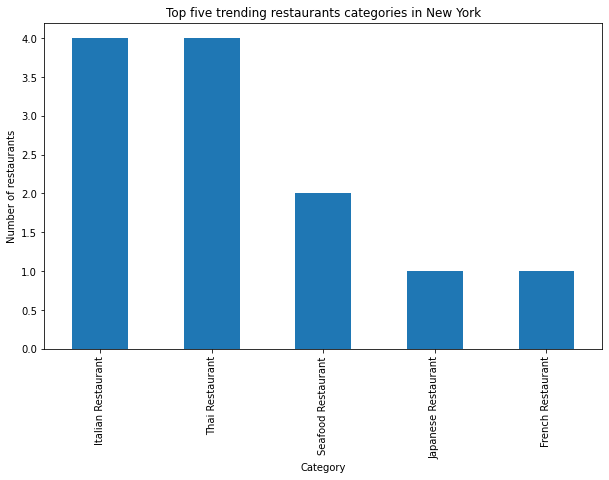

In [43]:
#plotting the top five restaurant categories
trending_restaurants.plot(kind='bar', figsize=(10, 6), legend=None)

plt.xlabel('Category') # add to x-label to the plot
plt.ylabel('Number of restaurants') # add y-label to the plot
plt.title('Top five trending restaurants categories in New York') # add title to the plot

plt.show()

## Getting the hotels data around Chicago city center and performing needed analysis

###### In this part, we will call the Foursquare API and search for hotels around Chicago city center. Then we will cluster the resulting venues using K-Means clustering to find areas were groups of hotels are located. Finally, we will find the centers of these areas and organize them in a data frame for later analysis.

In [45]:
C_lat = 41.8781
C_lon = -87.6298
search_query = 'Hotel'
radius = 100000
limit_hotels = 50

In [46]:
url_C = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, C_lat, C_lon, VERSION, search_query, radius, limit_hotels)
url_C

'https://api.foursquare.com/v2/venues/search?client_id=LQA5A1YTM25KN0TQT2GILWCCP2JLPMPQN20YN4ZY0QOTT2ZH&client_secret=0IXCMPXJLX3LFJZUOH33ZEQHRG2JIZQF3R4KKMPIJDWQNHMV&ll=41.8781,-87.6298&v=20210415&query=Hotel&radius=100000&limit=50'

In [47]:
results_C = requests.get(url_C).json()

In [48]:
hotels_C = results_C['response']['venues']

# tranform venues into a dataframe
hotels_df1 = pd.json_normalize(hotels_C)
hotels_df1.head()

,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,venuePage.id,delivery.id,delivery.url,delivery.provider.name,delivery.provider.icon.prefix,delivery.provider.icon.sizes,delivery.provider.icon.name,location.neighborhood
0,4a32eaf5f964a520bf9a1fe3,Renaissance Chicago Downtown Hotel,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",v-1619660710,False,1 West Upper Wacker Drive,at N State St,41.886221,-87.628321,"[{'label': 'display', 'lat': 41.88622055333085...",912,60601,US,Chicago,IL,United States,"[1 West Upper Wacker Drive (at N State St), Ch...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4ac9453ef964a52074bf20e3,Hotel Blake,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",v-1619660710,False,500 S Dearborn St,btwn W Harrison St & W Congress Plaza,41.875164,-87.629485,"[{'label': 'display', 'lat': 41.875164, 'lng':...",327,60605,US,Chicago,IL,United States,[500 S Dearborn St (btwn W Harrison St & W Con...,73965646,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,57ac13a4cd10a2bea58adcac,Kimpton Gray Hotel,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",v-1619660710,False,122 W. Monroe Street,NaN,41.880875,-87.631752,"[{'label': 'display', 'lat': 41.88087481612714...",348,60603,US,Chicago,IL,United States,"[122 W. Monroe Street, Chicago, IL 60603, Unit...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4adccfaff964a520173021e3,Trump International Hotel & Tower Chicago (Tru...,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",v-1619660710,False,401 N Wabash Ave,NaN,41.888938,-87.626354,"[{'label': 'display', 'lat': 41.8889377, 'lng'...",1239,60611,US,Chicago,IL,United States,"[401 N Wabash Ave, Chicago, IL 60611, United S...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4a330469f964a520f09a1fe3,Palmer House - A Hilton Hotel,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",v-1619660710,False,17 E Monroe St,btwn S State St & S Wabash Ave,41.880307,-87.626739,"[{'label': 'display', 'lat': 41.8803066, 'lng'...",353,60603,US,Chicago,IL,United States,[17 E Monroe St (btwn S State St & S Wabash Av...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns1 = ['name', 'categories'] + [col for col in hotels_df1.columns if col.startswith('location.')] + ['id']
hotels_df_filtered1 = hotels_df1.loc[:, filtered_columns1]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
hotels_df_filtered1['categories'] = hotels_df_filtered1.apply(get_category_type, axis=1)

# clean column names by keeping only last term
hotels_df_filtered1.columns = [column.split('.')[-1] for column in hotels_df_filtered1.columns]

hotels_df_filtered1.shape

(50, 16)

In [50]:
hotels_df_filtered1

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id
0,Renaissance Chicago Downtown Hotel,Hotel,1 West Upper Wacker Drive,at N State St,41.886221,-87.628321,"[{'label': 'display', 'lat': 41.88622055333085...",912,60601,US,Chicago,IL,United States,"[1 West Upper Wacker Drive (at N State St), Ch...",NaN,4a32eaf5f964a520bf9a1fe3
1,Hotel Blake,Hotel,500 S Dearborn St,btwn W Harrison St & W Congress Plaza,41.875164,-87.629485,"[{'label': 'display', 'lat': 41.875164, 'lng':...",327,60605,US,Chicago,IL,United States,[500 S Dearborn St (btwn W Harrison St & W Con...,NaN,4ac9453ef964a52074bf20e3
2,Kimpton Gray Hotel,Hotel,122 W. Monroe Street,NaN,41.880875,-87.631752,"[{'label': 'display', 'lat': 41.88087481612714...",348,60603,US,Chicago,IL,United States,"[122 W. Monroe Street, Chicago, IL 60603, Unit...",NaN,57ac13a4cd10a2bea58adcac
3,Trump International Hotel & Tower Chicago (Tru...,Hotel,401 N Wabash Ave,NaN,41.888938,-87.626354,"[{'label': 'display', 'lat': 41.8889377, 'lng'...",1239,60611,US,Chicago,IL,United States,"[401 N Wabash Ave, Chicago, IL 60611, United S...",NaN,4adccfaff964a520173021e3
4,Palmer House - A Hilton Hotel,Hotel,17 E Monroe St,btwn S State St & S Wabash Ave,41.880307,-87.626739,"[{'label': 'display', 'lat': 41.8803066, 'lng'...",353,60603,US,Chicago,IL,United States,[17 E Monroe St (btwn S State St & S Wabash Av...,NaN,4a330469f964a520f09a1fe3
5,The Congress Plaza Hotel,Hotel,520 S Michigan Ave,NaN,41.875162,-87.624654,"[{'label': 'display', 'lat': 41.8751616, 'lng'...",537,60605,US,Chicago,IL,United States,"[520 S Michigan Ave, Chicago, IL 60605, United...",NaN,4a7c4e54f964a52032ec1fe3
6,"Club Quarters Hotel, Central Loop",Hotel,111 W Adams St,at S Clark St,41.879266,-87.631186,"[{'label': 'display', 'lat': 41.87926599409459...",173,60603,US,Chicago,IL,United States,"[111 W Adams St (at S Clark St), Chicago, IL 6...",NaN,4840f34df964a5202f501fe3
7,Holiday Inn Hotel & Suites Chicago-Downtown,Hotel,506 W Harrison St,S Clinton S,41.874670,-87.639990,"[{'label': 'display', 'lat': 41.87466986242672...",926,60607,US,Chicago,IL,United States,"[506 W Harrison St (S Clinton S), Chicago, IL ...",NaN,4b5a8479f964a5204ac928e3
8,"The Gwen, a Luxury Collection Hotel, Michigan ...",Hotel,521 N Rush St,at Grand Ave,41.891100,-87.625265,"[{'label': 'display', 'lat': 41.8911003, 'lng'...",1495,60611,US,Chicago,IL,United States,"[521 N Rush St (at Grand Ave), Chicago, IL 606...",NaN,4ac52a77f964a520beb020e3
9,Silversmith Hotel Chicago Downtown,Hotel,10 S Wabash Ave,NaN,41.881498,-87.626170,"[{'label': 'display', 'lat': 41.88149827777068...",483,60603,US,Chicago,IL,United States,"[10 S Wabash Ave, Chicago, IL 60603, United St...",NaN,4b37fa03f964a5208d4925e3


In [51]:
hotels_df_filtered1 = hotels_df_filtered1[hotels_df_filtered1.categories == 'Hotel']
hotels_df_filtered1.head(10)

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id
0,Renaissance Chicago Downtown Hotel,Hotel,1 West Upper Wacker Drive,at N State St,41.886221,-87.628321,"[{'label': 'display', 'lat': 41.88622055333085...",912,60601,US,Chicago,IL,United States,"[1 West Upper Wacker Drive (at N State St), Ch...",NaN,4a32eaf5f964a520bf9a1fe3
1,Hotel Blake,Hotel,500 S Dearborn St,btwn W Harrison St & W Congress Plaza,41.875164,-87.629485,"[{'label': 'display', 'lat': 41.875164, 'lng':...",327,60605,US,Chicago,IL,United States,[500 S Dearborn St (btwn W Harrison St & W Con...,NaN,4ac9453ef964a52074bf20e3
2,Kimpton Gray Hotel,Hotel,122 W. Monroe Street,NaN,41.880875,-87.631752,"[{'label': 'display', 'lat': 41.88087481612714...",348,60603,US,Chicago,IL,United States,"[122 W. Monroe Street, Chicago, IL 60603, Unit...",NaN,57ac13a4cd10a2bea58adcac
3,Trump International Hotel & Tower Chicago (Tru...,Hotel,401 N Wabash Ave,NaN,41.888938,-87.626354,"[{'label': 'display', 'lat': 41.8889377, 'lng'...",1239,60611,US,Chicago,IL,United States,"[401 N Wabash Ave, Chicago, IL 60611, United S...",NaN,4adccfaff964a520173021e3
4,Palmer House - A Hilton Hotel,Hotel,17 E Monroe St,btwn S State St & S Wabash Ave,41.880307,-87.626739,"[{'label': 'display', 'lat': 41.8803066, 'lng'...",353,60603,US,Chicago,IL,United States,[17 E Monroe St (btwn S State St & S Wabash Av...,NaN,4a330469f964a520f09a1fe3
5,The Congress Plaza Hotel,Hotel,520 S Michigan Ave,NaN,41.875162,-87.624654,"[{'label': 'display', 'lat': 41.8751616, 'lng'...",537,60605,US,Chicago,IL,United States,"[520 S Michigan Ave, Chicago, IL 60605, United...",NaN,4a7c4e54f964a52032ec1fe3
6,"Club Quarters Hotel, Central Loop",Hotel,111 W Adams St,at S Clark St,41.879266,-87.631186,"[{'label': 'display', 'lat': 41.87926599409459...",173,60603,US,Chicago,IL,United States,"[111 W Adams St (at S Clark St), Chicago, IL 6...",NaN,4840f34df964a5202f501fe3
7,Holiday Inn Hotel & Suites Chicago-Downtown,Hotel,506 W Harrison St,S Clinton S,41.874670,-87.639990,"[{'label': 'display', 'lat': 41.87466986242672...",926,60607,US,Chicago,IL,United States,"[506 W Harrison St (S Clinton S), Chicago, IL ...",NaN,4b5a8479f964a5204ac928e3
8,"The Gwen, a Luxury Collection Hotel, Michigan ...",Hotel,521 N Rush St,at Grand Ave,41.891100,-87.625265,"[{'label': 'display', 'lat': 41.8911003, 'lng'...",1495,60611,US,Chicago,IL,United States,"[521 N Rush St (at Grand Ave), Chicago, IL 606...",NaN,4ac52a77f964a520beb020e3
9,Silversmith Hotel Chicago Downtown,Hotel,10 S Wabash Ave,NaN,41.881498,-87.626170,"[{'label': 'display', 'lat': 41.88149827777068...",483,60603,US,Chicago,IL,United States,"[10 S Wabash Ave, Chicago, IL 60603, United St...",NaN,4b37fa03f964a5208d4925e3


In [52]:
hotels_df_filtered1.reset_index(drop=True, inplace=True)
hotels_df_filtered1.head(10)

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id
0,Renaissance Chicago Downtown Hotel,Hotel,1 West Upper Wacker Drive,at N State St,41.886221,-87.628321,"[{'label': 'display', 'lat': 41.88622055333085...",912,60601,US,Chicago,IL,United States,"[1 West Upper Wacker Drive (at N State St), Ch...",NaN,4a32eaf5f964a520bf9a1fe3
1,Hotel Blake,Hotel,500 S Dearborn St,btwn W Harrison St & W Congress Plaza,41.875164,-87.629485,"[{'label': 'display', 'lat': 41.875164, 'lng':...",327,60605,US,Chicago,IL,United States,[500 S Dearborn St (btwn W Harrison St & W Con...,NaN,4ac9453ef964a52074bf20e3
2,Kimpton Gray Hotel,Hotel,122 W. Monroe Street,NaN,41.880875,-87.631752,"[{'label': 'display', 'lat': 41.88087481612714...",348,60603,US,Chicago,IL,United States,"[122 W. Monroe Street, Chicago, IL 60603, Unit...",NaN,57ac13a4cd10a2bea58adcac
3,Trump International Hotel & Tower Chicago (Tru...,Hotel,401 N Wabash Ave,NaN,41.888938,-87.626354,"[{'label': 'display', 'lat': 41.8889377, 'lng'...",1239,60611,US,Chicago,IL,United States,"[401 N Wabash Ave, Chicago, IL 60611, United S...",NaN,4adccfaff964a520173021e3
4,Palmer House - A Hilton Hotel,Hotel,17 E Monroe St,btwn S State St & S Wabash Ave,41.880307,-87.626739,"[{'label': 'display', 'lat': 41.8803066, 'lng'...",353,60603,US,Chicago,IL,United States,[17 E Monroe St (btwn S State St & S Wabash Av...,NaN,4a330469f964a520f09a1fe3
5,The Congress Plaza Hotel,Hotel,520 S Michigan Ave,NaN,41.875162,-87.624654,"[{'label': 'display', 'lat': 41.8751616, 'lng'...",537,60605,US,Chicago,IL,United States,"[520 S Michigan Ave, Chicago, IL 60605, United...",NaN,4a7c4e54f964a52032ec1fe3
6,"Club Quarters Hotel, Central Loop",Hotel,111 W Adams St,at S Clark St,41.879266,-87.631186,"[{'label': 'display', 'lat': 41.87926599409459...",173,60603,US,Chicago,IL,United States,"[111 W Adams St (at S Clark St), Chicago, IL 6...",NaN,4840f34df964a5202f501fe3
7,Holiday Inn Hotel & Suites Chicago-Downtown,Hotel,506 W Harrison St,S Clinton S,41.874670,-87.639990,"[{'label': 'display', 'lat': 41.87466986242672...",926,60607,US,Chicago,IL,United States,"[506 W Harrison St (S Clinton S), Chicago, IL ...",NaN,4b5a8479f964a5204ac928e3
8,"The Gwen, a Luxury Collection Hotel, Michigan ...",Hotel,521 N Rush St,at Grand Ave,41.891100,-87.625265,"[{'label': 'display', 'lat': 41.8911003, 'lng'...",1495,60611,US,Chicago,IL,United States,"[521 N Rush St (at Grand Ave), Chicago, IL 606...",NaN,4ac52a77f964a520beb020e3
9,Silversmith Hotel Chicago Downtown,Hotel,10 S Wabash Ave,NaN,41.881498,-87.626170,"[{'label': 'display', 'lat': 41.88149827777068...",483,60603,US,Chicago,IL,United States,"[10 S Wabash Ave, Chicago, IL 60603, United St...",NaN,4b37fa03f964a5208d4925e3


In [53]:
hotels_map1 = folium.Map(location=[C_lat, C_lon], zoom_start=15) # generate map centred around London

# add the hotels as blue circle markers
for lat, lng, label in zip(hotels_df_filtered1.lat, hotels_df_filtered1.lng, hotels_df_filtered1.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(hotels_map1)

# display map
hotels_map1

In [54]:
hotels_df_filtered1.shape

(41, 16)

In [55]:
#prepare hotels dataframe for clustering

#adding an ID number to each venue will help in re-assembling the data after clustering
id_n1 = list(range(1,len(hotels_df_filtered1)+1))
hotels_df_filtered1['id_n'] = id_n1
hotels_df_filtered1.head()

<ipython-input-55-05bf031164a8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotels_df_filtered1['id_n'] = id_n1


,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id,id_n
0,Renaissance Chicago Downtown Hotel,Hotel,1 West Upper Wacker Drive,at N State St,41.886221,-87.628321,"[{'label': 'display', 'lat': 41.88622055333085...",912,60601,US,Chicago,IL,United States,"[1 West Upper Wacker Drive (at N State St), Ch...",NaN,4a32eaf5f964a520bf9a1fe3,1
1,Hotel Blake,Hotel,500 S Dearborn St,btwn W Harrison St & W Congress Plaza,41.875164,-87.629485,"[{'label': 'display', 'lat': 41.875164, 'lng':...",327,60605,US,Chicago,IL,United States,[500 S Dearborn St (btwn W Harrison St & W Con...,NaN,4ac9453ef964a52074bf20e3,2
2,Kimpton Gray Hotel,Hotel,122 W. Monroe Street,NaN,41.880875,-87.631752,"[{'label': 'display', 'lat': 41.88087481612714...",348,60603,US,Chicago,IL,United States,"[122 W. Monroe Street, Chicago, IL 60603, Unit...",NaN,57ac13a4cd10a2bea58adcac,3
3,Trump International Hotel & Tower Chicago (Tru...,Hotel,401 N Wabash Ave,NaN,41.888938,-87.626354,"[{'label': 'display', 'lat': 41.8889377, 'lng'...",1239,60611,US,Chicago,IL,United States,"[401 N Wabash Ave, Chicago, IL 60611, United S...",NaN,4adccfaff964a520173021e3,4
4,Palmer House - A Hilton Hotel,Hotel,17 E Monroe St,btwn S State St & S Wabash Ave,41.880307,-87.626739,"[{'label': 'display', 'lat': 41.8803066, 'lng'...",353,60603,US,Chicago,IL,United States,[17 E Monroe St (btwn S State St & S Wabash Av...,NaN,4a330469f964a520f09a1fe3,5


In [56]:
X1=hotels_df_filtered1.loc[:,['id_n','lat','lng']]
X1.head(10)


,id_n,lat,lng
0,1,41.886221,-87.628321
1,2,41.875164,-87.629485
2,3,41.880875,-87.631752
3,4,41.888938,-87.626354
4,5,41.880307,-87.626739
5,6,41.875162,-87.624654
6,7,41.879266,-87.631186
7,8,41.874670,-87.639990
8,9,41.891100,-87.625265
9,10,41.881498,-87.626170


In [57]:
#clustering the hotels based on their locations 
kmeans1 = KMeans(n_clusters = 3, init ='k-means++') # hotels will be clustered in 3 groups
kmeans1.fit(X1[X1.columns[1:3]]) # Compute k-means clustering.
X1['cluster_label'] = kmeans1.fit_predict(X1[X1.columns[1:3]])
centers1 = kmeans1.cluster_centers_ # Coordinates of cluster centers.
labels1 = kmeans1.predict(X1[X1.columns[1:3]]) # Labels of each point
centers1 = kmeans1.cluster_centers_
print(centers1) #to show coordinates of the center for each cluster 
X1.head(10)

KMeans(n_clusters=3)

[[ 41.89296923 -87.62643236]
 [ 41.9478819  -87.6572832 ]
 [ 41.87815429 -87.6294338 ]]


,id_n,lat,lng,cluster_label
0,1,41.886221,-87.628321,0
1,2,41.875164,-87.629485,2
2,3,41.880875,-87.631752,2
3,4,41.888938,-87.626354,0
4,5,41.880307,-87.626739,2
5,6,41.875162,-87.624654,2
6,7,41.879266,-87.631186,2
7,8,41.874670,-87.639990,2
8,9,41.891100,-87.625265,0
9,10,41.881498,-87.626170,2


In [58]:
X1 = X1[['id_n','cluster_label']]
clustered_hotels1 = hotels_df_filtered1.merge(X1, left_on='id_n', right_on='id_n')
clustered_hotels1.head()

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id,id_n,cluster_label
0,Renaissance Chicago Downtown Hotel,Hotel,1 West Upper Wacker Drive,at N State St,41.886221,-87.628321,"[{'label': 'display', 'lat': 41.88622055333085...",912,60601,US,Chicago,IL,United States,"[1 West Upper Wacker Drive (at N State St), Ch...",NaN,4a32eaf5f964a520bf9a1fe3,1,0
1,Hotel Blake,Hotel,500 S Dearborn St,btwn W Harrison St & W Congress Plaza,41.875164,-87.629485,"[{'label': 'display', 'lat': 41.875164, 'lng':...",327,60605,US,Chicago,IL,United States,[500 S Dearborn St (btwn W Harrison St & W Con...,NaN,4ac9453ef964a52074bf20e3,2,2
2,Kimpton Gray Hotel,Hotel,122 W. Monroe Street,NaN,41.880875,-87.631752,"[{'label': 'display', 'lat': 41.88087481612714...",348,60603,US,Chicago,IL,United States,"[122 W. Monroe Street, Chicago, IL 60603, Unit...",NaN,57ac13a4cd10a2bea58adcac,3,2
3,Trump International Hotel & Tower Chicago (Tru...,Hotel,401 N Wabash Ave,NaN,41.888938,-87.626354,"[{'label': 'display', 'lat': 41.8889377, 'lng'...",1239,60611,US,Chicago,IL,United States,"[401 N Wabash Ave, Chicago, IL 60611, United S...",NaN,4adccfaff964a520173021e3,4,0
4,Palmer House - A Hilton Hotel,Hotel,17 E Monroe St,btwn S State St & S Wabash Ave,41.880307,-87.626739,"[{'label': 'display', 'lat': 41.8803066, 'lng'...",353,60603,US,Chicago,IL,United States,[17 E Monroe St (btwn S State St & S Wabash Av...,NaN,4a330469f964a520f09a1fe3,5,2


In [59]:
#count number of hotels in each area
hotel_count_C = clustered_hotels1['cluster_label'].value_counts().rename_axis('cluster_C').reset_index(name='counts')
hotel_count_C

,cluster_C,counts
0,0,27
1,2,13
2,1,1


In [60]:
#map showing each hotel with different color based on the cluster
map_clusters1 = folium.Map(location=[C_lat, C_lon], zoom_start=15)

# add markers to the map
marker_colors = ['red','green','blue']
for lat, lon, poi, cluster in zip(clustered_hotels1['lat'], clustered_hotels1['lng'], clustered_hotels1['name'], clustered_hotels1['cluster_label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=marker_colors[cluster],
        fill=True,
        fill_color=marker_colors[cluster],
        fill_opacity=0.7).add_to(map_clusters1)
       
map_clusters1 #show map

In [61]:
centers_df1 = pd.DataFrame(centers1, columns =['c_lat', 'c_lon'])
cluster_label1 = list(range(0,3))
centers_df1['cluster_label'] = cluster_label1
centers_df1

,c_lat,c_lon,cluster_label
0,41.892969,-87.626432,0
1,41.947882,-87.657283,1
2,41.878154,-87.629434,2


In [62]:
#map of centers
map_centers1 = folium.Map(location=[C_lat, C_lon], zoom_start=15)

# add markers to the map in different colors according to cluster
marker_colors = ['red','green','blue']
for lat, lon, poi, cluster in zip(centers_df1['c_lat'], centers_df1['c_lon'], centers_df1['cluster_label'], centers_df1['cluster_label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=marker_colors[cluster],
        fill=True,
        fill_color=marker_colors[cluster],
        fill_opacity=0.7).add_to(map_centers1)
       
map_centers1 #display the map showing 3 markers, one for each cluster

##  Getting the restaurants data from Foursquare around Chicago city center and analysing it.

##### In this section, we will call foursquare API again and call for trending venues around Chicago city center using the "explore" call, then we will clean the data, keep restaurants only, and classify these restaurants to one of the clusters created earlier using KNN classification.

##### To do this we will use the centers data created before as a training set for KNN, then we will predict the cluster to which each restaurant belongs to by finding the nearest center.

In [63]:
#creating the url to call on foursquare API

limit_restaurants = 100

url_C2 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    C_lat, 
    C_lon, 
    radius, 
    limit_restaurants)
url_C2

'https://api.foursquare.com/v2/venues/explore?&client_id=LQA5A1YTM25KN0TQT2GILWCCP2JLPMPQN20YN4ZY0QOTT2ZH&client_secret=0IXCMPXJLX3LFJZUOH33ZEQHRG2JIZQF3R4KKMPIJDWQNHMV&v=20210415&ll=41.8781,-87.6298&radius=100000&limit=100'

In [64]:
results_C = requests.get(url_C2).json()

In [65]:
#getting the needed data and put it in a pandas dataframe
restaurants_C = results_C['response']['groups'][0]['items']
    
restaurants_df_C = json_normalize(restaurants_C) # flatten JSON

# filter columns
filtered_columns_C = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
restaurants_df_C = restaurants_df_C.loc[:, filtered_columns_C]

# filter the category for each row
restaurants_df_C['venue.categories'] = restaurants_df_C.apply(get_category_type, axis=1)

# clean columns
restaurants_df_C.columns = [col.split(".")[-1] for col in restaurants_df_C.columns]

restaurants_df_C

<ipython-input-65-9dfe567562b6>:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  restaurants_df_C = json_normalize(restaurants_C) # flatten JSON


,name,categories,lat,lng
0,Symphony Center (Chicago Symphony Orchestra),Concert Hall,41.879275,-87.624680
1,The Art Institute of Chicago,Art Museum,41.879575,-87.623736
2,Millennium Park,Park,41.882598,-87.624126
3,Grant Park,Park,41.876626,-87.619263
4,The Chicago Theatre,Theater,41.885539,-87.627151
5,Lakefront Trail,Trail,41.883470,-87.625750
6,Chicago Riverwalk,Waterfront,41.887280,-87.627217
7,Chicago Athletic Association,Hotel,41.881625,-87.624942
8,Jay Pritzker Pavilion,Amphitheater,41.882614,-87.621782
9,Maggie Daley Park,Park,41.882905,-87.618846


In [66]:
#keeping only the venues with categories containing "Restaurant"
restaurants_df_cleaned_C = restaurants_df_C[restaurants_df_C['categories'].str.contains('Restaurant')].reset_index(drop=True)
print(restaurants_df_cleaned_C.shape) #number of restaurants
restaurants_df_cleaned_C.head()

(11, 4)


,name,categories,lat,lng
0,"Joe's Seafood, Prime Steak & Stone Crab",Seafood Restaurant,41.891828,-87.625444
1,Shaw's Crab House,Seafood Restaurant,41.889959,-87.627065
2,Aba,Mediterranean Restaurant,41.886852,-87.648885
3,Piccolo Sogno,Italian Restaurant,41.890852,-87.647698
4,The Purple Pig,Mediterranean Restaurant,41.890791,-87.625011


In [67]:
#creating a map of restaurants
restaurants_map_C = folium.Map(location=[C_lat, C_lon], zoom_start=15) # generate map centred around London

# add the hotels as yellow circle markers
for lat, lng, label in zip(restaurants_df_cleaned_C.lat, restaurants_df_cleaned_C.lng, restaurants_df_cleaned_C.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='brown',
        popup=label,
        fill = True,
        fill_color='borwn',
        fill_opacity=0.7
    ).add_to(restaurants_map_C)

# display map
restaurants_map_C

In [68]:
#preparing the data that will be used in KNN classification
Xhat_C=restaurants_df_cleaned_C.loc[:,['lat','lng']] #classification based on the location coordinates
print(Xhat_C.shape) #number of restaurants
Xhat_C.head(10) #show dataframe

(11, 2)


,lat,lng
0,41.891828,-87.625444
1,41.889959,-87.627065
2,41.886852,-87.648885
3,41.890852,-87.647698
4,41.890791,-87.625011
5,41.884246,-87.649820
6,41.884919,-87.660768
7,41.923927,-87.636615
8,41.918921,-87.648718
9,41.830780,-87.616906


In [69]:
#the centers dataframe to be used for training KNN
centers_df1

,c_lat,c_lon,cluster_label
0,41.892969,-87.626432,0
1,41.947882,-87.657283,1
2,41.878154,-87.629434,2


In [70]:
#selecting classification features and target variable
X_train_C = centers_df1[['c_lat', 'c_lon']].values
Y_train_C = centers_df1['cluster_label']

In [71]:
#importing KNN library
from sklearn.neighbors import KNeighborsClassifier


In [72]:
k = 1 #classification based on the nearest center
#Train Model and Predict  
neigh_C = KNeighborsClassifier(n_neighbors = k).fit(X_train_C,Y_train_C)
neigh_C

KNeighborsClassifier(n_neighbors=1)

In [73]:
#classify the restaurants based on the model created
yhat_C = neigh_C.predict(Xhat_C)
yhat_C[0:5]

array([0, 0, 2, 0, 0], dtype=int64)

In [74]:
#putting the results in a dataframe
KNN_results_C = pd.DataFrame(yhat_C, columns=['class'])
KNN_results_C

,class
0,0
1,0
2,2
3,0
4,0
5,2
6,2
7,1
8,1
9,2


In [75]:
#joining the results with the restaurants dataframe
restaurants_classified_C = pd.concat([restaurants_df_cleaned_C, KNN_results_C], axis=1, sort=False)

In [76]:
#view resulting dataframe
restaurants_classified_C

,name,categories,lat,lng,class
0,"Joe's Seafood, Prime Steak & Stone Crab",Seafood Restaurant,41.891828,-87.625444,0
1,Shaw's Crab House,Seafood Restaurant,41.889959,-87.627065,0
2,Aba,Mediterranean Restaurant,41.886852,-87.648885,2
3,Piccolo Sogno,Italian Restaurant,41.890852,-87.647698,0
4,The Purple Pig,Mediterranean Restaurant,41.890791,-87.625011,0
5,J.P. Graziano Grocery,Italian Restaurant,41.884246,-87.649820,2
6,Smyth,Restaurant,41.884919,-87.660768,2
7,Mon Ami Gabi,French Restaurant,41.923927,-87.636615,1
8,Café Ba-Ba-Reeba!,Tapas Restaurant,41.918921,-87.648718,1
9,Yassa African Restaurant,African Restaurant,41.830780,-87.616906,2


In [77]:
#show restaurante in each area in different color
map_rest_class_C = folium.Map(location=[C_lat, C_lon], zoom_start=15)

# add markers to the map
marker_colors = ['red','green','blue']
for lat, lon, poi, cluster in zip(restaurants_classified_C['lat'], restaurants_classified_C['lng'], restaurants_classified_C['name'], restaurants_classified_C['class']):
    label = folium.Popup(str(poi) + ' Class ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=marker_colors[cluster],
        fill=True,
        fill_color=marker_colors[cluster],
        fill_opacity=0.7).add_to(map_rest_class_C)
       
map_rest_class_C

### Finding the suitable spot to open restaurant around Chicago.

##### In this section we will see what category of restaurants is most trending and desired in center of Chicago. Since our restaurants data represent venues with highest foot-traffic then we will look at the frequency of restaurant category repetition as this are the venues recieving customers.

##### Then we will look at the number of restaurants in each of the three areas to choose the cluster of hotels with the minimum level of competion, as well as the number of hotels in that cluster to correctly evaluate the opportunity.

In [78]:
#count number of restaurants in each area
restaurants_count_C = restaurants_classified_C['class'].value_counts().rename_axis('class').reset_index(name='counts')
restaurants_count_C

,class,counts
0,0,5
1,2,4
2,1,2


In [79]:
#counting number of trending restaurants of each unique category
trending_restaurants_C = restaurants_classified_C['categories'].value_counts().rename_axis('categories').reset_index(name='counts')
trending_restaurants_C

,categories,counts
0,Italian Restaurant,2
1,Seafood Restaurant,2
2,Mediterranean Restaurant,2
3,French Restaurant,1
4,Restaurant,1
5,Molecular Gastronomy Restaurant,1
6,Tapas Restaurant,1
7,African Restaurant,1


In [80]:
#keeping the five most frequent categories
trending_restaurants_C = trending_restaurants_C.head()

In [81]:
#show top five categories
trending_restaurants_C

,categories,counts
0,Italian Restaurant,2
1,Seafood Restaurant,2
2,Mediterranean Restaurant,2
3,French Restaurant,1
4,Restaurant,1


In [82]:
#make "categories" as index for visiualization
trending_restaurants_C = trending_restaurants_C.set_index('categories')
trending_restaurants_C

,counts
categories,
Italian Restaurant,2
Seafood Restaurant,2
Mediterranean Restaurant,2
French Restaurant,1
Restaurant,1


In [83]:
#importing bar charts library
import matplotlib as mpl
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='categories'>

Text(0.5, 0, 'Category')

Text(0, 0.5, 'Number of restaurants')

Text(0.5, 1.0, 'Top five trending restaurants categories in Chicago')

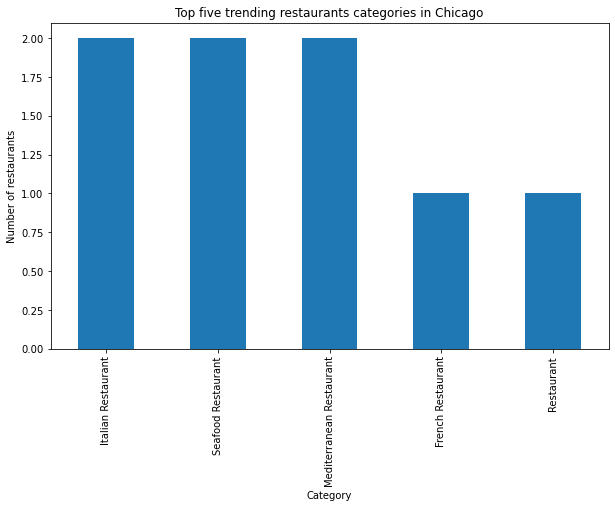

In [84]:
#plotting the top five restaurant categories
trending_restaurants_C.plot(kind='bar', figsize=(10, 6), legend=None)

plt.xlabel('Category') # add to x-label to the plot
plt.ylabel('Number of restaurants') # add y-label to the plot
plt.title('Top five trending restaurants categories in Chicago') # add title to the plot

plt.show()

## Getting the hotels data around Los Angeles city center and performing needed analysis

###### In this part, we will call the Foursquare API and search for hotels around Los Angeles city center. Then we will cluster the resulting venues using K-Means clustering to find areas were groups of hotels are located. Finally, we will find the centers of these areas and organize them in a data frame for later analysis.

In [86]:
LA_lat = 34.0522
LA_lon = -118.2437
search_query = 'Hotel'
radius = 100000
limit_hotels = 50

In [87]:
url_LA = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, LA_lat, LA_lon, VERSION, search_query, radius, limit_hotels)
url_LA

'https://api.foursquare.com/v2/venues/search?client_id=LQA5A1YTM25KN0TQT2GILWCCP2JLPMPQN20YN4ZY0QOTT2ZH&client_secret=0IXCMPXJLX3LFJZUOH33ZEQHRG2JIZQF3R4KKMPIJDWQNHMV&ll=34.0522,-118.2437&v=20210415&query=Hotel&radius=100000&limit=50'

In [88]:
results_LA = requests.get(url_LA).json()

In [89]:
hotels_LA = results_LA['response']['venues']

# tranform venues into a dataframe
hotels_df2 = pd.json_normalize(hotels_LA)
hotels_df2.head()

,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,venuePage.id,location.neighborhood,delivery.id,delivery.url,delivery.provider.name,delivery.provider.icon.prefix,delivery.provider.icon.sizes,delivery.provider.icon.name
0,4a62ae6cf964a52072c41fe3,"The Westin Bonaventure Hotel & Suites, Los Ang...","[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",v-1619660712,False,404 S Figueroa St,btwn 4th & 5th St,34.052777,-118.255596,"[{'label': 'display', 'lat': 34.0527773, 'lng'...",1099,90071,US,Los Angeles,CA,United States,"[404 S Figueroa St (btwn 4th & 5th St), Los An...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4a6b9a88f964a52052cf1fe3,Millennium Biltmore Hotel Los Angeles,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",v-1619660712,False,506 S Grand Ave,at 5th St,34.049813,-118.253938,"[{'label': 'display', 'lat': 34.049813, 'lng':...",980,90071,US,Los Angeles,CA,United States,"[506 S Grand Ave (at 5th St), Los Angeles, CA ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4c95fb98efecb713c816e89d,Wyndham Garden Hotel,[],v-1619660712,False,5757 Telegraph Rd,NaN,34.053335,-118.243448,"[{'label': 'display', 'lat': 34.05333536922002...",128,90040,US,Commerce,CA,United States,"[5757 Telegraph Rd, Commerce, CA 90040, United...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4a6be87ef964a5203ad01fe3,Omni Los Angeles Hotel at California Plaza,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",v-1619660712,False,251 S Olive St,NaN,34.052497,-118.250455,"[{'label': 'display', 'lat': 34.05249694980792...",623,90012,US,Los Angeles,CA,United States,"[251 S Olive St, Los Angeles, CA 90012, United...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4cd50b6876ab721ebce76a6a,Kyoto Grand Hotel Parking & Gardens Garage,"[{'id': '4c38df4de52ce0d596b336e1', 'name': 'P...",v-1619660712,False,120 S Los Angeles St,NaN,34.050526,-118.242682,"[{'label': 'display', 'lat': 34.050526, 'lng':...",208,90012,US,Los Angeles,CA,United States,"[120 S Los Angeles St, Los Angeles, CA 90012, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns2 = ['name', 'categories'] + [col for col in hotels_df2.columns if col.startswith('location.')] + ['id']
hotels_df_filtered2 = hotels_df2.loc[:, filtered_columns2]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
hotels_df_filtered2['categories'] = hotels_df_filtered2.apply(get_category_type, axis=1)

# clean column names by keeping only last term
hotels_df_filtered2.columns = [column.split('.')[-1] for column in hotels_df_filtered2.columns]

hotels_df_filtered2.shape

(50, 16)

In [91]:
hotels_df_filtered2

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id
0,"The Westin Bonaventure Hotel & Suites, Los Ang...",Hotel,404 S Figueroa St,btwn 4th & 5th St,34.052777,-118.255596,"[{'label': 'display', 'lat': 34.0527773, 'lng'...",1099,90071,US,Los Angeles,CA,United States,"[404 S Figueroa St (btwn 4th & 5th St), Los An...",NaN,4a62ae6cf964a52072c41fe3
1,Millennium Biltmore Hotel Los Angeles,Hotel,506 S Grand Ave,at 5th St,34.049813,-118.253938,"[{'label': 'display', 'lat': 34.049813, 'lng':...",980,90071,US,Los Angeles,CA,United States,"[506 S Grand Ave (at 5th St), Los Angeles, CA ...",NaN,4a6b9a88f964a52052cf1fe3
2,Wyndham Garden Hotel,None,5757 Telegraph Rd,NaN,34.053335,-118.243448,"[{'label': 'display', 'lat': 34.05333536922002...",128,90040,US,Commerce,CA,United States,"[5757 Telegraph Rd, Commerce, CA 90040, United...",NaN,4c95fb98efecb713c816e89d
3,Omni Los Angeles Hotel at California Plaza,Hotel,251 S Olive St,NaN,34.052497,-118.250455,"[{'label': 'display', 'lat': 34.05249694980792...",623,90012,US,Los Angeles,CA,United States,"[251 S Olive St, Los Angeles, CA 90012, United...",NaN,4a6be87ef964a5203ad01fe3
4,Kyoto Grand Hotel Parking & Gardens Garage,Parking,120 S Los Angeles St,NaN,34.050526,-118.242682,"[{'label': 'display', 'lat': 34.050526, 'lng':...",208,90012,US,Los Angeles,CA,United States,"[120 S Los Angeles St, Los Angeles, CA 90012, ...",NaN,4cd50b6876ab721ebce76a6a
5,Stay On Main Hotel,Hostel,640 S Main St,Los Angeles St,34.044292,-118.250672,"[{'label': 'display', 'lat': 34.04429171520181...",1090,90014,US,Los Angeles,CA,United States,"[640 S Main St (Los Angeles St), Los Angeles, ...",NaN,4f61d0a9e4b011d850db80f6
6,The Palm Woods Hotel,Residential Building (Apartment / Condo),The Palm Woods Hotel,Hollywood,34.054037,-118.241923,"[{'label': 'display', 'lat': 34.05403721919709...",262,90012,US,Los Angeles,CA,United States,"[The Palm Woods Hotel (Hollywood), Los Angeles...",NaN,505db930e0e2e3d789c50aeb
7,Ace Hotel Downtown Los Angeles,Hotel,929 S Broadway,at 9th St,34.041763,-118.256630,"[{'label': 'display', 'lat': 34.04176317207911...",1664,90015,US,Los Angeles,CA,United States,"[929 S Broadway (at 9th St), Los Angeles, CA 9...",NaN,4f10ae81e4b0253d4be8c453
8,Little Tokyo Hotel,Boarding House,327 1/2 E 1st St,NaN,34.050072,-118.239983,"[{'label': 'display', 'lat': 34.050072, 'lng':...",416,90012,US,Los Angeles,CA,United States,"[327 1/2 E 1st St, Los Angeles, CA 90012, Unit...",NaN,50fbaaf9e4b04f855604a2a7
9,Hotel Cafe - 2nd Stage,Music Venue,NaN,NaN,34.052234,-118.243685,"[{'label': 'display', 'lat': 34.0522342, 'lng'...",4,NaN,US,Los Angeles,CA,United States,"[Los Angeles, CA, United States]",NaN,59bf7980fd9d73213eebc94b


In [92]:
hotels_df_filtered2 = hotels_df_filtered2[hotels_df_filtered2.categories == 'Hotel']
hotels_df_filtered2.head(10)

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id
0,"The Westin Bonaventure Hotel & Suites, Los Ang...",Hotel,404 S Figueroa St,btwn 4th & 5th St,34.052777,-118.255596,"[{'label': 'display', 'lat': 34.0527773, 'lng'...",1099,90071,US,Los Angeles,CA,United States,"[404 S Figueroa St (btwn 4th & 5th St), Los An...",NaN,4a62ae6cf964a52072c41fe3
1,Millennium Biltmore Hotel Los Angeles,Hotel,506 S Grand Ave,at 5th St,34.049813,-118.253938,"[{'label': 'display', 'lat': 34.049813, 'lng':...",980,90071,US,Los Angeles,CA,United States,"[506 S Grand Ave (at 5th St), Los Angeles, CA ...",NaN,4a6b9a88f964a52052cf1fe3
3,Omni Los Angeles Hotel at California Plaza,Hotel,251 S Olive St,NaN,34.052497,-118.250455,"[{'label': 'display', 'lat': 34.05249694980792...",623,90012,US,Los Angeles,CA,United States,"[251 S Olive St, Los Angeles, CA 90012, United...",NaN,4a6be87ef964a5203ad01fe3
7,Ace Hotel Downtown Los Angeles,Hotel,929 S Broadway,at 9th St,34.041763,-118.256630,"[{'label': 'display', 'lat': 34.04176317207911...",1664,90015,US,Los Angeles,CA,United States,"[929 S Broadway (at 9th St), Los Angeles, CA 9...",NaN,4f10ae81e4b0253d4be8c453
10,Miyako Hotel,Hotel,328 E 1st St,NaN,34.049749,-118.240111,"[{'label': 'display', 'lat': 34.04974909864657...",428,90012,US,Los Angeles,CA,United States,"[328 E 1st St, Los Angeles, CA 90012, United S...",NaN,4a47ab0ff964a520eca91fe3
11,Hotel Indigo,Hotel,899 Francisco St,NaN,34.047450,-118.264410,"[{'label': 'display', 'lat': 34.0474501, 'lng'...",1981,90017,US,Los Angeles,CA,United States,"[899 Francisco St, Los Angeles, CA 90017, Unit...",NaN,58ba082192ca4c138f46851c
12,Cambria Hotel Los Angeles Downtown,Hotel,419 S Spring St,NaN,34.048567,-118.248695,"[{'label': 'display', 'lat': 34.0485666, 'lng'...",613,90013,US,Los Angeles,CA,United States,"[419 S Spring St, Los Angeles, CA 90013, Unite...",NaN,5f724c15cb22ec0662cadf50
13,The L.A. Grand Hotel Downtown,Hotel,333 S Figueroa St,NaN,34.054883,-118.255312,"[{'label': 'display', 'lat': 34.0548833, 'lng'...",1111,90071,US,Los Angeles,CA,United States,"[333 S Figueroa St, Los Angeles, CA 90071, Uni...",NaN,5043fa66e4b09ae79ca8953e
14,The NoMad Hotel Los Angeles,Hotel,649 S Olive St,at W 7th St,34.047021,-118.255441,"[{'label': 'display', 'lat': 34.047021, 'lng':...",1226,90014,US,Los Angeles,CA,United States,"[649 S Olive St (at W 7th St), Los Angeles, CA...",NaN,584c5cdfd772f952a50c6aef
15,O Hotel,Hotel,819 S Flower St,NaN,34.046915,-118.260789,"[{'label': 'display', 'lat': 34.04691521616299...",1682,90017,US,Los Angeles,CA,United States,"[819 S Flower St, Los Angeles, CA 90017, Unite...",NaN,4b188beff964a520ffd323e3


In [93]:
hotels_df_filtered2.reset_index(drop=True, inplace=True)
hotels_df_filtered2.head(10)

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id
0,"The Westin Bonaventure Hotel & Suites, Los Ang...",Hotel,404 S Figueroa St,btwn 4th & 5th St,34.052777,-118.255596,"[{'label': 'display', 'lat': 34.0527773, 'lng'...",1099,90071,US,Los Angeles,CA,United States,"[404 S Figueroa St (btwn 4th & 5th St), Los An...",NaN,4a62ae6cf964a52072c41fe3
1,Millennium Biltmore Hotel Los Angeles,Hotel,506 S Grand Ave,at 5th St,34.049813,-118.253938,"[{'label': 'display', 'lat': 34.049813, 'lng':...",980,90071,US,Los Angeles,CA,United States,"[506 S Grand Ave (at 5th St), Los Angeles, CA ...",NaN,4a6b9a88f964a52052cf1fe3
2,Omni Los Angeles Hotel at California Plaza,Hotel,251 S Olive St,NaN,34.052497,-118.250455,"[{'label': 'display', 'lat': 34.05249694980792...",623,90012,US,Los Angeles,CA,United States,"[251 S Olive St, Los Angeles, CA 90012, United...",NaN,4a6be87ef964a5203ad01fe3
3,Ace Hotel Downtown Los Angeles,Hotel,929 S Broadway,at 9th St,34.041763,-118.256630,"[{'label': 'display', 'lat': 34.04176317207911...",1664,90015,US,Los Angeles,CA,United States,"[929 S Broadway (at 9th St), Los Angeles, CA 9...",NaN,4f10ae81e4b0253d4be8c453
4,Miyako Hotel,Hotel,328 E 1st St,NaN,34.049749,-118.240111,"[{'label': 'display', 'lat': 34.04974909864657...",428,90012,US,Los Angeles,CA,United States,"[328 E 1st St, Los Angeles, CA 90012, United S...",NaN,4a47ab0ff964a520eca91fe3
5,Hotel Indigo,Hotel,899 Francisco St,NaN,34.047450,-118.264410,"[{'label': 'display', 'lat': 34.0474501, 'lng'...",1981,90017,US,Los Angeles,CA,United States,"[899 Francisco St, Los Angeles, CA 90017, Unit...",NaN,58ba082192ca4c138f46851c
6,Cambria Hotel Los Angeles Downtown,Hotel,419 S Spring St,NaN,34.048567,-118.248695,"[{'label': 'display', 'lat': 34.0485666, 'lng'...",613,90013,US,Los Angeles,CA,United States,"[419 S Spring St, Los Angeles, CA 90013, Unite...",NaN,5f724c15cb22ec0662cadf50
7,The L.A. Grand Hotel Downtown,Hotel,333 S Figueroa St,NaN,34.054883,-118.255312,"[{'label': 'display', 'lat': 34.0548833, 'lng'...",1111,90071,US,Los Angeles,CA,United States,"[333 S Figueroa St, Los Angeles, CA 90071, Uni...",NaN,5043fa66e4b09ae79ca8953e
8,The NoMad Hotel Los Angeles,Hotel,649 S Olive St,at W 7th St,34.047021,-118.255441,"[{'label': 'display', 'lat': 34.047021, 'lng':...",1226,90014,US,Los Angeles,CA,United States,"[649 S Olive St (at W 7th St), Los Angeles, CA...",NaN,584c5cdfd772f952a50c6aef
9,O Hotel,Hotel,819 S Flower St,NaN,34.046915,-118.260789,"[{'label': 'display', 'lat': 34.04691521616299...",1682,90017,US,Los Angeles,CA,United States,"[819 S Flower St, Los Angeles, CA 90017, Unite...",NaN,4b188beff964a520ffd323e3


In [94]:
hotels_map2 = folium.Map(location=[LA_lat, LA_lon], zoom_start=15) # generate map centred around London

# add the hotels as blue circle markers
for lat, lng, label in zip(hotels_df_filtered2.lat, hotels_df_filtered2.lng, hotels_df_filtered2.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(hotels_map2)

# display map
hotels_map2

In [95]:
hotels_df_filtered2.shape

(25, 16)

In [96]:
#prepare hotels dataframe for clustering

#adding an ID number to each venue will help in re-assembling the data after clustering
id_n2 = list(range(1,len(hotels_df_filtered2)+1))
hotels_df_filtered2['id_n'] = id_n2
hotels_df_filtered2.head()

<ipython-input-96-7e75b2946273>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotels_df_filtered2['id_n'] = id_n2


,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id,id_n
0,"The Westin Bonaventure Hotel & Suites, Los Ang...",Hotel,404 S Figueroa St,btwn 4th & 5th St,34.052777,-118.255596,"[{'label': 'display', 'lat': 34.0527773, 'lng'...",1099,90071,US,Los Angeles,CA,United States,"[404 S Figueroa St (btwn 4th & 5th St), Los An...",NaN,4a62ae6cf964a52072c41fe3,1
1,Millennium Biltmore Hotel Los Angeles,Hotel,506 S Grand Ave,at 5th St,34.049813,-118.253938,"[{'label': 'display', 'lat': 34.049813, 'lng':...",980,90071,US,Los Angeles,CA,United States,"[506 S Grand Ave (at 5th St), Los Angeles, CA ...",NaN,4a6b9a88f964a52052cf1fe3,2
2,Omni Los Angeles Hotel at California Plaza,Hotel,251 S Olive St,NaN,34.052497,-118.250455,"[{'label': 'display', 'lat': 34.05249694980792...",623,90012,US,Los Angeles,CA,United States,"[251 S Olive St, Los Angeles, CA 90012, United...",NaN,4a6be87ef964a5203ad01fe3,3
3,Ace Hotel Downtown Los Angeles,Hotel,929 S Broadway,at 9th St,34.041763,-118.256630,"[{'label': 'display', 'lat': 34.04176317207911...",1664,90015,US,Los Angeles,CA,United States,"[929 S Broadway (at 9th St), Los Angeles, CA 9...",NaN,4f10ae81e4b0253d4be8c453,4
4,Miyako Hotel,Hotel,328 E 1st St,NaN,34.049749,-118.240111,"[{'label': 'display', 'lat': 34.04974909864657...",428,90012,US,Los Angeles,CA,United States,"[328 E 1st St, Los Angeles, CA 90012, United S...",NaN,4a47ab0ff964a520eca91fe3,5


In [97]:
X2=hotels_df_filtered2.loc[:,['id_n','lat','lng']]
X2.head(10)


,id_n,lat,lng
0,1,34.052777,-118.255596
1,2,34.049813,-118.253938
2,3,34.052497,-118.250455
3,4,34.041763,-118.256630
4,5,34.049749,-118.240111
5,6,34.047450,-118.264410
6,7,34.048567,-118.248695
7,8,34.054883,-118.255312
8,9,34.047021,-118.255441
9,10,34.046915,-118.260789


In [98]:
#clustering the hotels based on their locations 
kmeans2 = KMeans(n_clusters = 3, init ='k-means++') # hotels will be clustered in 3 groups
kmeans2.fit(X2[X2.columns[1:3]]) # Compute k-means clustering.
X2['cluster_label'] = kmeans2.fit_predict(X2[X2.columns[1:3]])
centers2 = kmeans2.cluster_centers_ # Coordinates of cluster centers.
labels2 = kmeans2.predict(X2[X2.columns[1:3]]) # Labels of each point
centers2 = kmeans2.cluster_centers_
print(centers2) #to show coordinates of the center for each cluster 
X2.head(10)

KMeans(n_clusters=3)

[[  34.06823173 -118.38325983]
 [  34.05015605 -118.25290578]
 [  34.06331811 -118.30060076]]


,id_n,lat,lng,cluster_label
0,1,34.052777,-118.255596,1
1,2,34.049813,-118.253938,1
2,3,34.052497,-118.250455,1
3,4,34.041763,-118.256630,1
4,5,34.049749,-118.240111,1
5,6,34.047450,-118.264410,1
6,7,34.048567,-118.248695,1
7,8,34.054883,-118.255312,1
8,9,34.047021,-118.255441,1
9,10,34.046915,-118.260789,1


In [99]:
X2 = X2[['id_n','cluster_label']]
clustered_hotels2 = hotels_df_filtered2.merge(X2, left_on='id_n', right_on='id_n')
clustered_hotels2.head()

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id,id_n,cluster_label
0,"The Westin Bonaventure Hotel & Suites, Los Ang...",Hotel,404 S Figueroa St,btwn 4th & 5th St,34.052777,-118.255596,"[{'label': 'display', 'lat': 34.0527773, 'lng'...",1099,90071,US,Los Angeles,CA,United States,"[404 S Figueroa St (btwn 4th & 5th St), Los An...",NaN,4a62ae6cf964a52072c41fe3,1,1
1,Millennium Biltmore Hotel Los Angeles,Hotel,506 S Grand Ave,at 5th St,34.049813,-118.253938,"[{'label': 'display', 'lat': 34.049813, 'lng':...",980,90071,US,Los Angeles,CA,United States,"[506 S Grand Ave (at 5th St), Los Angeles, CA ...",NaN,4a6b9a88f964a52052cf1fe3,2,1
2,Omni Los Angeles Hotel at California Plaza,Hotel,251 S Olive St,NaN,34.052497,-118.250455,"[{'label': 'display', 'lat': 34.05249694980792...",623,90012,US,Los Angeles,CA,United States,"[251 S Olive St, Los Angeles, CA 90012, United...",NaN,4a6be87ef964a5203ad01fe3,3,1
3,Ace Hotel Downtown Los Angeles,Hotel,929 S Broadway,at 9th St,34.041763,-118.256630,"[{'label': 'display', 'lat': 34.04176317207911...",1664,90015,US,Los Angeles,CA,United States,"[929 S Broadway (at 9th St), Los Angeles, CA 9...",NaN,4f10ae81e4b0253d4be8c453,4,1
4,Miyako Hotel,Hotel,328 E 1st St,NaN,34.049749,-118.240111,"[{'label': 'display', 'lat': 34.04974909864657...",428,90012,US,Los Angeles,CA,United States,"[328 E 1st St, Los Angeles, CA 90012, United S...",NaN,4a47ab0ff964a520eca91fe3,5,1


In [100]:
#count number of hotels in each area
hotel_count_LA = clustered_hotels2['cluster_label'].value_counts().rename_axis('cluster_LA').reset_index(name='counts')
hotel_count_LA

,cluster_LA,counts
0,1,20
1,0,4
2,2,1


In [101]:
#map showing each hotel with different color based on the cluster
map_clusters2 = folium.Map(location=[LA_lat, LA_lon], zoom_start=15)

# add markers to the map
marker_colors = ['red','green','blue']
for lat, lon, poi, cluster in zip(clustered_hotels2['lat'], clustered_hotels2['lng'], clustered_hotels2['name'], clustered_hotels2['cluster_label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=marker_colors[cluster],
        fill=True,
        fill_color=marker_colors[cluster],
        fill_opacity=0.7).add_to(map_clusters2)
       
map_clusters2 #show map

In [102]:
centers_df2 = pd.DataFrame(centers2, columns =['c_lat', 'c_lon'])
cluster_label2 = list(range(0,3))
centers_df2['cluster_label'] = cluster_label2
centers_df2

,c_lat,c_lon,cluster_label
0,34.068232,-118.383260,0
1,34.050156,-118.252906,1
2,34.063318,-118.300601,2


In [103]:
#map of centers
map_centers2 = folium.Map(location=[LA_lat, LA_lon], zoom_start=15)

# add markers to the map in different colors according to cluster
marker_colors = ['red','green','blue']
for lat, lon, poi, cluster in zip(centers_df2['c_lat'], centers_df2['c_lon'], centers_df2['cluster_label'], centers_df2['cluster_label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=marker_colors[cluster],
        fill=True,
        fill_color=marker_colors[cluster],
        fill_opacity=0.7).add_to(map_centers2)
       
map_centers2 #display the map showing 3 markers, one for each cluster

##  Getting the restaurants data from Foursquare around Los Angeles city center and analysing it.

##### In this section, we will call foursquare API again and call for trending venues around Los Angeles city center using the "explore" call, then we will clean the data, keep restaurants only, and classify these restaurants to one of the clusters created earlier using KNN classification.

##### To do this we will use the centers data created before as a training set for KNN, then we will predict the cluster to which each restaurant belongs to by finding the nearest center.

In [104]:
#creating the url to call on foursquare API

limit_restaurants = 100

url_LA2 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    LA_lat, 
    LA_lon, 
    radius, 
    limit_restaurants)
url_LA2

'https://api.foursquare.com/v2/venues/explore?&client_id=LQA5A1YTM25KN0TQT2GILWCCP2JLPMPQN20YN4ZY0QOTT2ZH&client_secret=0IXCMPXJLX3LFJZUOH33ZEQHRG2JIZQF3R4KKMPIJDWQNHMV&v=20210415&ll=34.0522,-118.2437&radius=100000&limit=100'

In [105]:
results_LA = requests.get(url_LA2).json()

In [106]:
#getting the needed data and put it in a pandas dataframe
restaurants_LA = results_LA['response']['groups'][0]['items']
    
restaurants_df_LA = json_normalize(restaurants_LA) # flatten JSON

# filter columns
filtered_columns_LA = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
restaurants_df_LA = restaurants_df_LA.loc[:, filtered_columns_LA]

# filter the category for each row
restaurants_df_LA['venue.categories'] = restaurants_df_LA.apply(get_category_type, axis=1)

# clean columns
restaurants_df_LA.columns = [col.split(".")[-1] for col in restaurants_df_LA.columns]

restaurants_df_LA

<ipython-input-106-01c7906110c6>:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  restaurants_df_LA = json_normalize(restaurants_LA) # flatten JSON


,name,categories,lat,lng
0,Walt Disney Concert Hall,Concert Hall,34.055511,-118.249284
1,The Last Bookstore,Bookstore,34.047620,-118.249852
2,The Broad,Art Museum,34.054474,-118.250051
3,Hauser & Wirth,Art Gallery,34.046095,-118.234801
4,Salt & Straw,Ice Cream Shop,34.046065,-118.235473
5,KazuNori: The Original Hand Roll Bar,Sushi Restaurant,34.047716,-118.247452
6,Grand Central Market,Market,34.050675,-118.248741
7,Vista Hermosa Park,Park,34.061601,-118.256857
8,Wurstküche,German Restaurant,34.045520,-118.236131
9,Wax Candy,Salon / Barbershop,34.042901,-118.253010


In [107]:
#keeping only the venues with categories containing "Restaurant"
restaurants_df_cleaned_LA = restaurants_df_LA[restaurants_df_LA['categories'].str.contains('Restaurant')].reset_index(drop=True)
print(restaurants_df_cleaned_LA.shape) #number of restaurants
restaurants_df_cleaned_LA.head()

(13, 4)


,name,categories,lat,lng
0,KazuNori: The Original Hand Roll Bar,Sushi Restaurant,34.047716,-118.247452
1,Wurstküche,German Restaurant,34.045520,-118.236131
2,Bavel,Mediterranean Restaurant,34.041506,-118.232955
3,Dama Fashion District,Latin American Restaurant,34.035199,-118.253182
4,Bestia,Italian Restaurant,34.033637,-118.229278


In [108]:
#creating a map of restaurants
restaurants_map_LA = folium.Map(location=[LA_lat, LA_lon], zoom_start=15) # generate map centred around London

# add the hotels as yellow circle markers
for lat, lng, label in zip(restaurants_df_cleaned_LA.lat, restaurants_df_cleaned_LA.lng, restaurants_df_cleaned_LA.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='brown',
        popup=label,
        fill = True,
        fill_color='borwn',
        fill_opacity=0.6
    ).add_to(restaurants_map_LA)

# display map
restaurants_map_LA

In [109]:
#preparing the data that will be used in KNN classification
Xhat_LA=restaurants_df_cleaned_LA.loc[:,['lat','lng']] #classification based on the location coordinates
print(Xhat_LA.shape) #number of restaurants
Xhat_LA.head(10) #show dataframe

(13, 2)


,lat,lng
0,34.047716,-118.247452
1,34.045520,-118.236131
2,34.041506,-118.232955
3,34.035199,-118.253182
4,34.033637,-118.229278
5,34.063828,-118.297364
6,34.107472,-118.254308
7,34.116959,-118.262060
8,34.064140,-118.343871
9,34.099063,-118.337444


In [110]:
#the centers dataframe to be used for training KNN
centers_df2

,c_lat,c_lon,cluster_label
0,34.068232,-118.383260,0
1,34.050156,-118.252906,1
2,34.063318,-118.300601,2


In [111]:
#selecting classification features and target variable
X_train_LA = centers_df2[['c_lat', 'c_lon']].values
Y_train_LA = centers_df2['cluster_label']

In [112]:
#importing KNN library
from sklearn.neighbors import KNeighborsClassifier


In [113]:
k = 1 #classification based on the nearest center
#Train Model and Predict  
neigh_LA = KNeighborsClassifier(n_neighbors = k).fit(X_train_LA,Y_train_LA)
neigh_LA

KNeighborsClassifier(n_neighbors=1)

In [114]:
#classify the restaurants based on the model created
yhat_LA = neigh_LA.predict(Xhat_LA)
yhat_LA[0:5]

array([1, 1, 1, 1, 1], dtype=int64)

In [115]:
#putting the results in a dataframe
KNN_results_LA = pd.DataFrame(yhat_LA, columns=['class'])
KNN_results_LA

,class
0,1
1,1
2,1
3,1
4,1
5,2
6,1
7,2
8,0
9,2


In [116]:
#joining the results with the restaurants dataframe
restaurants_classified_LA = pd.concat([restaurants_df_cleaned_LA, KNN_results_LA], axis=1, sort=False)

In [117]:
#view resulting dataframe
restaurants_classified_LA

,name,categories,lat,lng,class
0,KazuNori: The Original Hand Roll Bar,Sushi Restaurant,34.047716,-118.247452,1
1,Wurstküche,German Restaurant,34.045520,-118.236131,1
2,Bavel,Mediterranean Restaurant,34.041506,-118.232955,1
3,Dama Fashion District,Latin American Restaurant,34.035199,-118.253182,1
4,Bestia,Italian Restaurant,34.033637,-118.229278,1
5,Kang Ho Dong Baek Jeong,Korean Restaurant,34.063828,-118.297364,2
6,Salazar,Mexican Restaurant,34.107472,-118.254308,1
7,Dune,Mediterranean Restaurant,34.116959,-118.262060,2
8,République,French Restaurant,34.064140,-118.343871,0
9,L’Antica Pizzeria da Michele,Italian Restaurant,34.099063,-118.337444,2


In [118]:
#show restaurante in each area in different color
map_rest_class_LA = folium.Map(location=[LA_lat, LA_lon], zoom_start=15)

# add markers to the map
marker_colors = ['red','green','blue']
for lat, lon, poi, cluster in zip(restaurants_classified_LA['lat'], restaurants_classified_LA['lng'], restaurants_classified_LA['name'], restaurants_classified_LA['class']):
    label = folium.Popup(str(poi) + ' Class ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=marker_colors[cluster],
        fill=True,
        fill_color=marker_colors[cluster],
        fill_opacity=0.7).add_to(map_rest_class_LA)
       
map_rest_class_LA

### Finding the suitable spot to open restaurant around Los Angeles.

##### In this section we will see what category of restaurants is most trending and desired in center of Los Angeles. Since our restaurants data represent venues with highest foot-traffic then we will look at the frequency of restaurant category repetition as this are the venues recieving customers.

##### Then we will look at the number of restaurants in each of the three areas to choose the cluster of hotels with the minimum level of competion, as well as the number of hotels in that cluster to correctly evaluate the opportunity.

In [119]:
#count number of restaurants in each area
restaurants_count_LA = restaurants_classified_LA['class'].value_counts().rename_axis('class').reset_index(name='counts')
restaurants_count_LA

,class,counts
0,1,7
1,2,3
2,0,3


In [120]:
#counting number of trending restaurants of each unique category
trending_restaurants_LA = restaurants_classified_LA['categories'].value_counts().rename_axis('categories').reset_index(name='counts')
trending_restaurants_LA

,categories,counts
0,Italian Restaurant,3
1,Mediterranean Restaurant,2
2,Japanese Restaurant,1
3,Korean Restaurant,1
4,French Restaurant,1
5,Mexican Restaurant,1
6,German Restaurant,1
7,Latin American Restaurant,1
8,Cuban Restaurant,1
9,Sushi Restaurant,1


In [121]:
#keeping the five most frequent categories
trending_restaurants_LA = trending_restaurants_LA.head()

In [122]:
#show top five categories
trending_restaurants_LA

,categories,counts
0,Italian Restaurant,3
1,Mediterranean Restaurant,2
2,Japanese Restaurant,1
3,Korean Restaurant,1
4,French Restaurant,1


In [123]:
#make "categories" as index for visiualization
trending_restaurants_LA = trending_restaurants_LA.set_index('categories')
trending_restaurants_LA

,counts
categories,
Italian Restaurant,3
Mediterranean Restaurant,2
Japanese Restaurant,1
Korean Restaurant,1
French Restaurant,1


In [124]:
#importing bar charts library
import matplotlib as mpl
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='categories'>

Text(0.5, 0, 'Category')

Text(0, 0.5, 'Number of restaurants')

Text(0.5, 1.0, 'Top five trending restaurants categories in Los Angles')

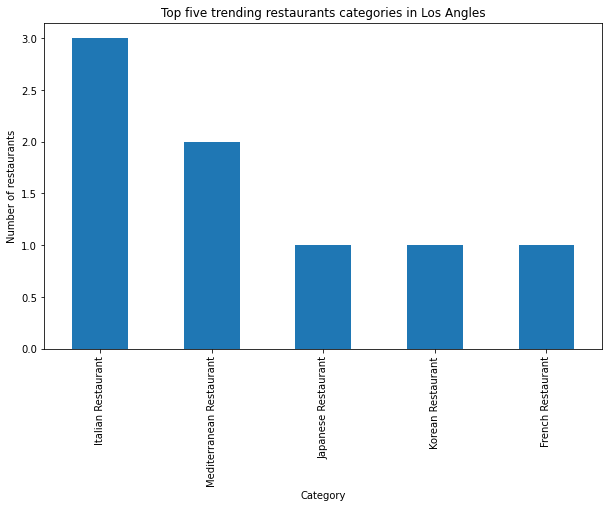

In [125]:
#plotting the top five restaurant categories
trending_restaurants_LA.plot(kind='bar', figsize=(10, 6), legend=None)

plt.xlabel('Category') # add to x-label to the plot
plt.ylabel('Number of restaurants') # add y-label to the plot
plt.title('Top five trending restaurants categories in Los Angles') # add title to the plot

plt.show()